# Super Mario Bros

## 1. Setup Mario

In [1]:
#!pip install gym_super_mario_bros==7.3.0 nes_py

In [2]:
# import the game
import gym_super_mario_bros
# import the joypad wrapper
from nes_py.wrappers import JoypadSpace
# import the SIMPLIFIED controls
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT


In [3]:
# Setup game
env = gym_super_mario_bros.make('SuperMarioBros-v0')
# wrapping it this way, ai takes shorter time how to learn the movements.
env = JoypadSpace(env, SIMPLE_MOVEMENT)


In [4]:
SIMPLE_MOVEMENT

[['NOOP'],
 ['right'],
 ['right', 'A'],
 ['right', 'B'],
 ['right', 'A', 'B'],
 ['A'],
 ['left']]

In [5]:
# Create a flag, restart or not
done = True
# # Loop through each frame in the game
# for step in range(100000):
#     # Start the game to begin with
#     if done:
#         # Start the game
#         env.reset()
#     # Do random actions
#     state, reward, done, info = env.step(env.action_space.sample())
#     # Show the game on the screen
#     env.render()
# # Close the game    
# env.close()

In [6]:
# Close the game    
env.close()

## 2. Preprocess Environment

In [7]:
# Import Frame Stacker Wrapper and GrayScaling Wrapper
from gym.wrappers import  GrayScaleObservation
# Import Vectorization Wrappers
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv
# Import Matplotlib to show the impact of frame stacking
from matplotlib import pyplot as plt

In [8]:
# 1. Create the base environment
env = gym_super_mario_bros.make('SuperMarioBros-v0')
# 2. Simplify the controls 
env = JoypadSpace(env, SIMPLE_MOVEMENT)
# # 3. Grayscale
env = GrayScaleObservation(env, keep_dim=True)
# 4. Wrap inside the Dummy Environment
env = DummyVecEnv([lambda: env])
# # 5. Stack the frames
env = VecFrameStack(env, 4, channels_order='last')

In [9]:
state = env.reset()

In [25]:
#Let mario jump
state, reward, done, info = env.step([5])

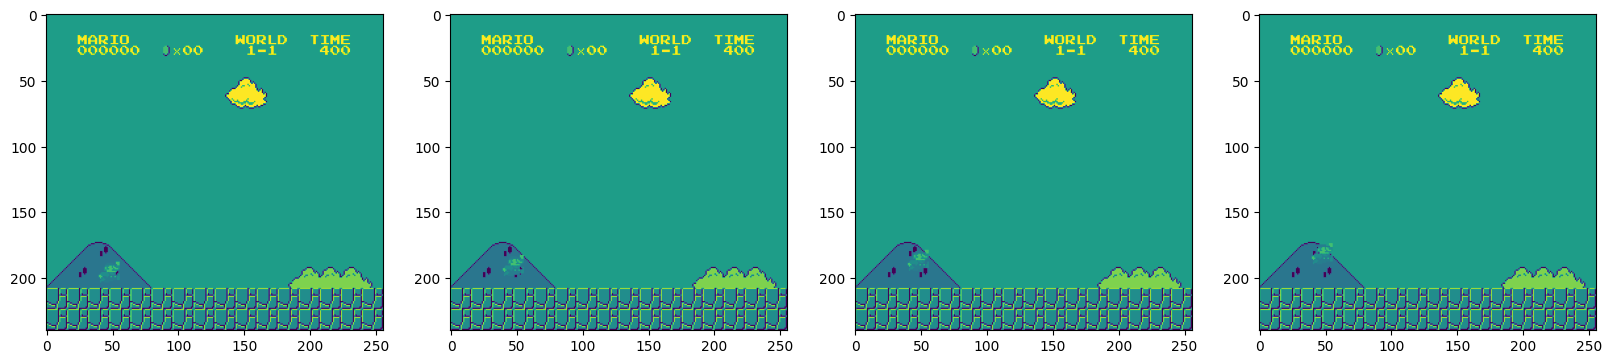

In [26]:
plt.figure(figsize=(20,16))
for idx in range(state.shape[3]):
    plt.subplot(1,4,idx+1)
    plt.imshow(state[0][:,:,idx])
plt.show()

## 3. Train the RL Model

In [12]:
# Import os for file path management
import os 
# Import PPO for algos
from stable_baselines3 import PPO
# Import Base Callback for saving models
from stable_baselines3.common.callbacks import BaseCallback

In [13]:
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True

In [14]:
CHECKPOINT_DIR = './train/'
LOG_DIR = './logs/'

In [15]:
# Setup model saving callback
callback = TrainAndLoggingCallback(check_freq=10000, save_path=CHECKPOINT_DIR)

In [16]:
# This is the AI model started
model = PPO('CnnPolicy', env, verbose=1, tensorboard_log=LOG_DIR, learning_rate=0.000001, 
            n_steps=512) 

Using cpu device
Wrapping the env in a VecTransposeImage.


In [27]:
# Train the AI model, this is where the AI model starts to learn
model.learn(total_timesteps=1000000, callback=callback)

Logging to ./logs/PPO_1


c:\Users\Warmtebron\anaconda3\envs\rnEnv\lib\site-packages\gym_super_mario_bros\smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


----------------------------
| time/              |     |
|    fps             | 154 |
|    iterations      | 1   |
|    time_elapsed    | 3   |
|    total_timesteps | 512 |
----------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 30            |
|    iterations           | 2             |
|    time_elapsed         | 33            |
|    total_timesteps      | 1024          |
| train/                  |               |
|    approx_kl            | 2.8712093e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.95         |
|    explained_variance   | -0.000645     |
|    learning_rate        | 1e-06         |
|    loss                 | 103           |
|    n_updates            | 10            |
|    policy_gradient_loss | -0.000505     |
|    value_loss           | 358           |
-------------------------------------------
-----

## 4. Test it out

In [ ]:
# Load model
model = PPO.load('./train/best_model_1000000')

In [ ]:
state = env.reset()

In [ ]:
# Start the game 
state = env.reset()
# Loop through the game
while True: 
    
    action, _ = model.predict(state)
    state, reward, done, info = env.step(action)
    env.render()